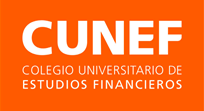

# Máster en Data Science - Machine Learning

# Predicción de fraude mediante el uso de modelos de Machine Learning
##### <font color='dodgerblue' face='Montserrat'>Autor: Rodrigo Fernandez Campos</font>
## DataSet: Bank Account Fraud Dataset Suite (NeurIPS 2022)

# <font size=25><b>Pruebas y experimentos</b></font>

* Pruebas de Modelos
* Pruebas de tamaños de sets con Undersampling
* Pruebas de búsqueda de hiperparámetros

In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored, cprint
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder
import warnings
import sys

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import lightgbm
from lightgbm.sklearn import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import NearMiss, TomekLinks

from sklearn.metrics import balanced_accuracy_score,\
                            accuracy_score,average_precision_score, precision_recall_curve, roc_curve,\
                            auc, recall_score, precision_score, confusion_matrix, f1_score
import pickle
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Funciones

In [4]:
sys.path.append('../src/')
import functions_rfc as fr
sys.path.remove('../src/')

### Constantes:
seed=10

***
# Importo y preparo los datasets

## Importo datasets procesados con anterioridad

In [2]:
df_fraud_train = pd.read_csv('../data/interim/df_fraud_train.csv')

df_fraud_train.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month,fraud_bool
0,0.9,0.237329,-1,80,40,0.013515,-1.041418,AC,1589,5840.486860,7660.279574,6353.443336,0,12,CA,100,1,BA,0,1,-1,0,2000.0,0,INTERNET,3.436651,other,1,1,0,0
1,0.9,0.176307,-1,54,40,0.019225,-0.835103,AC,882,3442.067872,4575.631214,5571.455566,1,7,CF,106,0,BC,0,1,-1,0,200.0,0,INTERNET,6.356665,linux,0,1,2,0
2,0.1,0.265706,157,156,40,0.011588,37.078740,AA,1298,1196.731284,4008.487554,4212.552556,728,2,CA,137,0,BE,1,1,11,1,500.0,0,INTERNET,17.815440,windows,1,1,6,0
3,0.9,0.089557,35,5,20,0.025159,37.116540,AA,1337,9563.602945,2838.222720,3508.471021,429,11,CA,242,1,BC,0,1,21,0,200.0,0,INTERNET,4.443607,other,1,1,2,0
4,0.7,0.882855,-1,117,40,0.003562,-0.332094,AC,1333,1954.199605,2811.816273,4267.415243,1,2,CA,225,1,BA,1,1,-1,0,1000.0,0,INTERNET,3.170467,windows,1,1,5,0


Aplico el preprocesamiento mediante el uso de mis funciones de pipeline y feature selection.

Además, dejo un dataset sin recortes de variables, para ver si es significativa la diferencia de métricas o no.

In [5]:
df_fraud_train_cut = fr.feature_selection(fr.preprocessing(df_fraud_train).fit_transform(df_fraud_train, df_fraud_train.fraud_bool))

df_fraud_train = fr.preprocessing(df_fraud_train).fit_transform(df_fraud_train, df_fraud_train.fraud_bool)

df_fraud_train_cut.shape, df_fraud_train.shape

((700000, 30), (700000, 35))

In [6]:
df_fraud_train_cut.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,month,employment_status,housing_status,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,payment_type,email_is_free,phone_home_valid,has_other_cards,keep_alive_session,fraud_bool
0,1.162077,-0.886368,-0.401845,-0.074208,0.525351,-0.188421,-0.479960,0.016703,1.626476,-0.401099,0.495149,-0.444664,-0.977307,3.042105,-0.511240,-0.101291,-1.487757,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.016808,1,0,0,1,0
1,1.162077,-1.097272,-0.401845,-0.368282,0.525351,-0.187361,-0.469766,-0.686182,0.776665,-0.398925,-0.498521,-0.358539,-0.977307,-0.647840,-0.147405,-0.101291,-0.582983,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.016506,0,0,0,0,0
2,-1.594037,-0.788294,3.185180,0.785393,0.525351,-0.188779,1.403621,-0.272603,-0.700097,1.181371,-1.492190,0.086437,0.012945,-0.032850,1.280361,-0.101291,1.226563,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.005201,0,1,1,1,0
3,1.162077,-1.397097,0.415452,-0.922499,-1.137270,-0.186258,1.405489,-0.233830,-1.465245,0.531428,0.296415,1.593616,0.838155,-0.647840,-0.385773,-0.101291,-0.582983,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.005220,1,0,0,1,0
4,0.473048,1.344685,-0.401845,0.344282,0.525351,-0.190269,-0.444912,-0.237807,-0.640476,-0.398925,-1.492190,1.349597,-0.977307,0.992135,-0.544406,-0.101291,0.774176,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.016445,1,1,0,1,0


Separo en X e y:

In [7]:
X_train_0 = df_fraud_train_cut.drop('fraud_bool', axis=1)
y_train_0 = df_fraud_train_cut['fraud_bool']

## Separación en train y validation estratificado

Debido a que voy a probar muchos modelos, decido realizar una separación en train y validation, para poder medir sin tener que tocar el set de test, que se mantiene inmaculado.

Además, como planeo utilizar ténicas de undersampling y oversampling, el train y val separados quedan guardados en una variable y el df original en otra, para luego reutilizar los datos del set de validación en caso de tener que realizar un undersampling u oversampling en el modelo final a medir con el test.

In [8]:
X_train_1, X_val, y_train_1, y_val = train_test_split(df_fraud_train_cut.drop('fraud_bool',axis=1)
                                                  ,df_fraud_train_cut['fraud_bool']
                                                  ,stratify=df_fraud_train_cut['fraud_bool']
                                                  ,test_size=0.3
                                                  ,random_state=seed)

X_train_complete, X_val_complete, y_train_complete, y_val_complete = train_test_split(df_fraud_train.drop('fraud_bool',axis=1)
                                                                                      ,df_fraud_train['fraud_bool']
                                                                                      ,stratify=df_fraud_train['fraud_bool']
                                                                                      ,test_size=0.3
                                                                                      ,random_state=seed)

In [9]:
X_train_1.shape, X_val.shape, X_train_complete.shape, X_val_complete.shape

((490000, 29), (210000, 29), (490000, 34), (210000, 34))

***
# Unsersampling + Oversampling

Investigando en internet me he topado con una técnica que me parece interesante, que es una combinación proporcional de undersampling y oversampling. He decidido probarlo mediante la aplicación de un Pipeline en donde se aplican secuencialmente las técnicas.

Me parece una aplicación acertada para casos como el de este dataset en donde los datos están extremadamente desbalanceados, al punto de que un undersampling aplicado directamente eliminaría una cantidad demasiado alta de información, mientras que un oversampling podría generar un sesgo por la cantidad enorme de datos sintéticos a generar. Es por eso que un acercamiento entre ambos parece una solución interesante, al menos sobre el papel.

Existen dentro de Imbalanced-Learning de SKL dos funciones con una combinación interna de oversampling y undersampling, pero al probarlas no parecen estar optimizadas y el costo computacional que me requieren es demasiado alto, por eso generaré y aplicaré mi propio Pipeline manualmente.

Entonces, para lidiar con el desbalanceo terminaré aplicando:

1. Split estatificado (SE) --> (realizado en Notebook 02)
2. RandomUnderSampling
3. SMOTE OverSampling
4. Pipeline con sampling mix --> (SMOTE OverSampling + Random UnderSampling)


In [10]:
# El tamaño y distribución actual del DataSet de train son los siguientes:
X_train_1.shape,y_train_1.value_counts(),y_train_1.value_counts(normalize=True)

((490000, 29),
 fraud_bool
 0    484596
 1      5404
 Name: count, dtype: int64,
 fraud_bool
 0    0.988971
 1    0.011029
 Name: proportion, dtype: float64)

#### 1. Random Undersampling

In [11]:
undersamp = RandomUnderSampler(sampling_strategy=0.08, random_state=seed)
X_train_under, y_train_under = undersamp.fit_resample(X_train_1, y_train_1)

In [12]:
X_train_under.shape,y_train_under.value_counts(),y_train_under.value_counts(normalize=True)

((72954, 29),
 fraud_bool
 0    67550
 1     5404
 Name: count, dtype: int64,
 fraud_bool
 0    0.925926
 1    0.074074
 Name: proportion, dtype: float64)

In [13]:
1 - X_train_under.shape[0] / X_train_1.shape[0]

0.8511142857142857

Logramos el cometido, el dataset está balanceado, pero solo nos quedamos con 27k datos, es decir que perdimos el 94% de nuestro dataset, 
dato que es al menos recalcable. Habrá que ver como funcionan los modelos con una reducción tan grande del dataset.

# Modelos

## Probando detalles de modelos

In [7]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [8]:
tree.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(tree.predict(X_test),y_test)

0.97741

In [10]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(tree.predict(X_test),y_test)
cf_matrix

array([[292885,   2971],
       [  3806,    338]], dtype=int64)

In [13]:
tree2 = DecisionTreeClassifier()
tree2.fit(X_train_cut,y_train)

DecisionTreeClassifier()

In [14]:
accuracy_score(tree2.predict(X_test_cut),y_test)

0.9771666666666666

In [17]:
confusion_matrix(tree2.predict(X_test_cut),y_test)

array([[292813,   2972],
       [  3878,    337]], dtype=int64)

In [24]:
tree3 = DecisionTreeClassifier()
tree3.fit(X_train_samp,y_train_samp)

DecisionTreeClassifier()

In [29]:
accuracy_score(tree3.predict(X_test_cut),y_test)

0.9575233333333333

In [31]:
confusion_matrix(tree3.predict(X_test_cut),y_test)

array([[286604,   2656],
       [ 10087,    653]], dtype=int64)

In [11]:
lr = LogisticRegression()

LogisticRegression()

In [18]:
lr.fit(X_train_scaled,y_train)

LogisticRegression()

In [19]:
lr.predict(X_test_scaled)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [14]:
accuracy_score(lr.predict(X_test),y_test)

0.98897

In [26]:
from sklearn.metrics import balanced_accuracy_score,average_precision_score, precision_recall_curve, roc_curve, auc, recall_score, precision_score, confusion_matrix, f1_score,\
fbeta_score

In [24]:
precision_score(lr.predict(X_test_scaled),y_test), recall_score(lr.predict(X_test_scaled),y_test), f1_score(lr.predict(X_test_scaled),y_test)

(0.0075551526140828044, 0.625, 0.014929829799940283)

In [25]:
confusion_matrix(lr.predict(X_test_scaled),y_test)

array([[296676,   3284],
       [    15,     25]], dtype=int64)

In [27]:
fbeta_score(lr.predict(X_test_scaled),y_test, beta=2)

0.036033439031421165

## Pruebas Undersampling y LightGBM

In [19]:
nm = NearMiss(sampling_strategy=0.08)
X_train_nm, y_train_nm = nm.fit_resample(X_train_1, y_train_1)

In [15]:
X_train_nm.shape,y_train_nm.value_counts(),y_train_nm.value_counts(normalize=True)

((10808, 29),
 fraud_bool
 0    5404
 1    5404
 Name: count, dtype: int64,
 fraud_bool
 0    0.5
 1    0.5
 Name: proportion, dtype: float64)

In [16]:
tl = TomekLinks(sampling_strategy=0.08)
X_train_tl, y_train_tl = nm.fit_resample(X_train_1, y_train_1)

In [17]:
X_train_tl.shape,y_train_tl.value_counts(),y_train_tl.value_counts(normalize=True)

((10808, 29),
 fraud_bool
 0    5404
 1    5404
 Name: count, dtype: int64,
 fraud_bool
 0    0.5
 1    0.5
 Name: proportion, dtype: float64)

In [20]:
%%time
lgbm = LGBMClassifier(verbosity=-1)
datasets_train = [[X_train_nm, y_train_nm]\
                 ,[X_train_tl, y_train_tl]\
                 ,[X_train_under, y_train_under]\
                 ]

datasets_validation = [[X_val, y_val]\
                      ,[X_val, y_val]\
                      ,[X_val, y_val]\
                       ]

names = ['Set NM','Set TL','Set RU']

for train, val, name in zip(datasets_train, datasets_validation, names):
    lgbm.fit(train[0], train[1])   
    accuracy = accuracy_score(val[1],lgbm.predict(val[0]))
    balanced_acc = balanced_accuracy_score(val[1],lgbm.predict(val[0]))
    f1 = f1_score(val[1],lgbm.predict(val[0])) # (y_true, y_pred)
    c_matrix = confusion_matrix(val[1],lgbm.predict(val[0]))
    precision = precision_score(val[1],lgbm.predict(val[0]))
    recall = recall_score(val[1],lgbm.predict(val[0]))
    print(f'\033[1m{name}\033[0m')
    print("model score: %.3f" % lgbm.score(val[0], val[1]))
    print(f"""
    accuracy = {accuracy}
    balanced accuracy = {balanced_acc}
    precision = {precision}
    recall = {recall}
    \033[1mf1_score = {f1}\033[0m
    confusion matrix:
    {c_matrix}
    ____________________________________________________________________________________________
    """)

Set NM
model score: 0.643

    accuracy = 0.6426380952380952
    balanced accuracy = 0.621855662942695
    precision = 0.018420913232333934
    recall = 0.6006044905008635
    f1_score = 0.035745490054993063
    confusion matrix:
    [[133563  74121]
 [   925   1391]]
    ____________________________________________________________________________________________
    
Set TL
model score: 0.194

    accuracy = 0.1944809523809524
    balanced accuracy = 0.5624346418876905
    precision = 0.012699265732427523
    recall = 0.9386873920552677
    f1_score = 0.02505950768556888
    confusion matrix:
    [[ 38667 169017]
 [   142   2174]]
    ____________________________________________________________________________________________
    
Set RU
model score: 0.980

    accuracy = 0.9795809523809523
    balanced accuracy = 0.6310269298125599
    precision = 0.1960542540073983
    recall = 0.27461139896373055
    f1_score = 0.22877697841726619
    confusion matrix:
    [[205076   2608]
 [  1680

In [17]:
def metrics_summ(y_true, y_pred):
    print(f'''
Accuracy: {accuracy_score(y_true,y_pred):.5f}
Balanced Accuracy: {balanced_accuracy_score(y_true,y_pred):.5f}
\033[1mF2 score: {fbeta_score(y_true,y_pred, beta=2):.5f}\033[0m
\033[1mF1 score: {f1_score(y_true,y_pred):.5f}\033[0m
Precision: {precision_score(y_true,y_pred):.5f}
Recall: {recall_score(y_true,y_pred):.5f}

Confusion Matrix:
{confusion_matrix(y_true,y_pred)}''')

In [24]:
%%time

strategies = [0.05, 0.08, 0.1, 0.15, 0.2, 0.25]
lgbm = LGBMClassifier(verbosity=-1)

for strategy in strategies:
    undersamp = RandomUnderSampler(sampling_strategy=strategy, random_state=seed)
    X_train_ru, y_train_ru = undersamp.fit_resample(X_train_1, y_train_1)
    lgbm.fit(X_train_ru, y_train_ru)   
    print(f'\033[1m{strategy}\033[0m')
    print("model score: %.3f" % lgbm.score(X_val, y_val))
    fr.metrics_summ(y_val, lgbm.predict(X_val))
    print("____________________________________________________________________________________________")

0.05
model score: 0.985

Accuracy: 0.98451
Balanced Accuracy: 0.58890
F2 score: 0.19313
F1 score: 0.20794
Precision: 0.23841
Recall: 0.18437

Confusion Matrix:
[[206320   1364]
 [  1889    427]]
____________________________________________________________________________________________
0.08
model score: 0.980

Accuracy: 0.97958
Balanced Accuracy: 0.63103
F2 score: 0.25424
F1 score: 0.22878
Precision: 0.19605
Recall: 0.27461

Confusion Matrix:
[[205076   2608]
 [  1680    636]]
____________________________________________________________________________________________
0.1
model score: 0.975

Accuracy: 0.97536
Balanced Accuracy: 0.65558
F2 score: 0.27888
F1 score: 0.22730
Precision: 0.17374
Recall: 0.32858

Confusion Matrix:
[[204065   3619]
 [  1555    761]]
____________________________________________________________________________________________
0.15
model score: 0.966

Accuracy: 0.96597
Balanced Accuracy: 0.69801
F2 score: 0.30575
F1 score: 0.21556
Precision: 0.14452
Recall: 0.42

Luego de varias pruebas he decidido elegir el strategy de 0.08. Podría haber elegido el 0.1 o el 0.15 también, si, pero de esa manera se debalancean
más el f1 y el f2, mientras que, además, se ha podido notar en éste y otros entrenamientos posteriores como es difícil que el f2 supere el 0.31, y mediante la hiperparametrización se puede llegar a esos valores, si necesidad de ceder tanto f1 (precisión en este caso). Creo que es la solución más eficiente, teniendo en cuenta además los tratamientos a futuro de hiperparametrización y también del seteo del threshold, en donde también prefiero que no se alejen tanto los óptimos de f2 y f1.

In [33]:
X_train_extra_var = X_train_under.copy()
X_val_extra_var = X_val.copy()

X_train_extra_var['crs_x_pcl_ratio'] = X_train_extra_var['credit_risk_score'] / X_train_extra_var['proposed_credit_limit']
X_val_extra_var['crs_x_pcl_ratio'] = X_val_extra_var['credit_risk_score'] / X_val_extra_var['proposed_credit_limit']

X_train_extra_var.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,device_os_other,device_os_linux,device_os_windows,device_os_macintosh,device_os_x11,keep_alive_session,device_distinct_emails_8w,month,crs_x_pcl_ratio
566543,0.8,0.129004,56,10,30,0.016274,-0.760933,1.0,2034,4847.050264,10,10,0.0,109,1,2.0,0,1,200.0,0,5.150540,0,1,0,0,0,1,1,3,0.545000
636294,0.1,0.231047,31,3,20,0.007882,-1.319822,1.0,1076,4801.842797,12,11,0.0,96,1,2.0,0,0,500.0,0,15.680771,0,0,0,1,0,1,1,4,0.192000
82003,0.7,0.550407,-1,324,50,0.028341,-0.604352,3.0,1228,5519.625841,174,2,1.0,218,0,0.0,0,0,1500.0,0,8.389204,0,0,1,0,0,0,1,2,0.145333
474606,0.4,0.682156,-1,252,40,0.019537,-0.983700,1.0,1239,4377.519574,2119,2,0.0,114,0,4.0,1,0,200.0,0,3.341758,0,0,0,1,0,1,1,5,0.570000
515774,0.9,0.278175,98,20,40,0.517795,-0.709431,1.0,1049,4312.921908,35,11,0.0,53,0,0.0,0,0,500.0,0,3.257548,0,0,0,1,0,0,1,5,0.106000


In [36]:
%%time
lgbm = LGBMClassifier(num_leaves=171\
                      ,n_estimators=500\
                      ,min_data_in_leaf=1600\
                      ,max_depth=10\
                      ,learning_rate=0.05
                      ,verbosity=-1)

lgbm.fit(X_train_extra_var,y_train_under)

y_pred = lgbm.predict(X_val_extra_var)

metrics_summ(y_val, y_pred)


Accuracy: 0.97849
Balanced Accuracy: 0.64222
F2 score: 0.26893
F1 score: 0.23428
Precision: 0.19286
Recall: 0.29836

Confusion Matrix:
[[204792   2892]
 [  1625    691]]
CPU times: total: 38 s
Wall time: 15.9 s


El modelo no mejora en caso de crear una nueva variable que unifique a dos correlacionadas. Además, esto podría sesgar al modelo, por lo que descarto la idea

In [36]:
X_train_under.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,device_os_other,device_os_linux,device_os_windows,device_os_macintosh,device_os_x11,keep_alive_session,device_distinct_emails_8w,month
566543,0.8,0.129004,56,10,30,0.016274,-0.760933,1.0,2034,4847.050264,10,10,0.0,109,1,2.0,0,15,1,200.0,0,5.150540,0,1,0,0,0,1,1,3
636294,0.1,0.231047,31,3,20,0.007882,-1.319822,1.0,1076,4801.842797,12,11,0.0,96,1,2.0,0,28,0,500.0,0,15.680771,0,0,0,1,0,1,1,4
82003,0.7,0.550407,-1,324,50,0.028341,-0.604352,3.0,1228,5519.625841,174,2,1.0,218,0,0.0,0,1,0,1500.0,0,8.389204,0,0,1,0,0,0,1,2
474606,0.4,0.682156,-1,252,40,0.019537,-0.983700,1.0,1239,4377.519574,2119,2,0.0,114,0,4.0,1,28,0,200.0,0,3.341758,0,0,0,1,0,1,1,5
515774,0.9,0.278175,98,20,40,0.517795,-0.709431,1.0,1049,4312.921908,35,11,0.0,53,0,0.0,0,1,0,500.0,0,3.257548,0,0,0,1,0,0,1,5


In [67]:
X_train_cut = X_train_under.drop(['foreign_request'], axis=1)
X_val_cut = X_val.drop(['foreign_request'], axis=1)

In [66]:
%%time
lgbm = LGBMClassifier(num_leaves=171\
                      ,n_estimators=500\
                      ,min_data_in_leaf=1600\
                      ,max_depth=10\
                      ,learning_rate=0.05
                      ,verbosity=-1)

lgbm.fit(X_train_cut,y_train_under)

y_pred = lgbm.predict(X_val_cut)

fr.metrics_summ(y_val, y_pred)


Accuracy: 0.97842
Balanced Accuracy: 0.64432
F2 score: 0.27211
F1 score: 0.23631
Precision: 0.19381
Recall: 0.30268

Confusion Matrix:
[[204768   2916]
 [  1615    701]]
CPU times: total: 16.2 s
Wall time: 6.1 s


Si sigo eliminando variables el modelo tampoco mejora, al contrario, empeora

### Prueba

In [35]:
%%time
lgbm = LGBMClassifier(num_leaves=171\
                      ,n_estimators=500\
                      ,min_data_in_leaf=1600\
                      ,max_depth=10\
                      ,learning_rate=0.05
                      ,verbosity=-1)

lgbm.fit(X_train_under,y_train_under)

y_pred = lgbm.predict(X_val)

fr.metrics_summ(y_val, y_pred)


Accuracy: 0.97852
Balanced Accuracy: 0.64415
F2 score: 0.27218
F1 score: 0.23685
Precision: 0.19471
Recall: 0.30225

Confusion Matrix:
[[204789   2895]
 [  1616    700]]
CPU times: total: 16.6 s
Wall time: 5.58 s


In [ ]:
%%time
f2_scorer = make_scorer(fbeta_score, beta=2)

lgbm = LGBMClassifier(verbosity=-1)
param_grid = { 
    'max_depth' : [3,5,7,9,11]
    ,'num_leaves' : [round(2**3/1.5),round(2**5/1.5),round(2**7/1.5), round(2**9/1.5), round(2**11/1.5)] # La documentación de LightGBM comenta que num_leaves se relaciona con el max_depth así: (num_leaves = (2^max_depth/1.5))
    ,'min_data_in_leaf' :[1200,1400,1600,1800,2000]
    ,'n_estimators ': [200,300,400,500,600,700]
    ,'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1]
}

scoring = {'f2':f2_scorer,'f1':'f1','accuracy':'accuracy', 'balanced_accuracy':'balanced_accuracy', 'precision':'precision', 'recall':'recall','roc_auc':'roc_auc'}

CV_rs = RandomizedSearchCV(lgbm, param_grid, n_iter=30, cv=10, random_state=seed, n_jobs=2, scoring=scoring, refit='f2')

CV_rs.fit(X_train_2, y_train_2)  
print(CV_rs.best_params_)    
print(CV_rs.best_score_)

## Prueba de tiempos LightGBM vs XGBoost

In [17]:
%%time
lgbm = LGBMClassifier(n_estimators=500, max_depth=10)
lgbm.fit(X_train_under, y_train_under)
y_pred_lgbm = lgbm.predict(X_val)
fr.metrics_summ(y_val, y_pred_lgbm)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5404, number of negative: 67550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2724
[LightGBM] [Info] Number of data points in the train set: 72954, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074074 -> initscore=-2.525729
[LightGBM] [Info] Start training from score -2.525729
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

Accuracy: 0.97843
Balanced Accuracy: 0.63258
F2 scor

In [16]:
%%time
xgb = XGBClassifier(n_estimators=500, max_depth=10) # # solo determino estos dos parámetros importantes en cuanto al tiempo para que sea comparable al LightGBM
xgb.fit(X_train_under, y_train_under)
y_pred_xgb = xgb.predict(X_val)
fr.metrics_summ(y_val, y_pred_xgb)


Accuracy: 0.97843
Balanced Accuracy: 0.63130
F2 score: 0.25082
F1 score: 0.22031
Precision: 0.18317
Recall: 0.27634

Confusion Matrix:
[[204830   2854]
 [  1676    640]]
CPU times: total: 3min 33s
Wall time: 32.3 s


Los resultados son bastante buenos, aunque muy levemente peores que los del LightGBM. Mientras que el tiempo de procesamiento fue 8 veces superior!

In [20]:
%%time
gbc = GradientBoostingClassifier(n_estimators=500, max_depth=10) # # solo determino estos dos parámetros importantes en cuanto al tiempo para que sea comparable al LightGBM
gbc.fit(X_train_under, y_train_under)
y_pred_gbc = gbc.predict(X_val)
fr.metrics_summ(y_val, y_pred_gbc)


Accuracy: 0.98099
Balanced Accuracy: 0.60911
F2 score: 0.22081
F1 score: 0.20978
Precision: 0.19364
Recall: 0.22884

Confusion Matrix:
[[205477   2207]
 [  1786    530]]
CPU times: total: 16min 49s
Wall time: 19min 22s


Ni hablar de los tiempos de procesamiento del Gradient Boosting, claramente peores en resultados y en tiempo